In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

warnings.filterwarnings('ignore')

In [2]:
migration_df_age_group = pd.read_csv('PEA03.20231022T221016.csv')
population_df = pd.read_csv('PEA11.20231013T111046.csv')

In [3]:
population_df.head()

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02076V03371,Single Year of Age,C02199V02655,Sex,UNIT,VALUE
0,PEA11,Population estimates from 1926,1926,1926,-,All ages,-,Both sexes,Number,2971992
1,PEA11,Population estimates from 1926,1926,1926,-,All ages,1,Male,Number,1506889
2,PEA11,Population estimates from 1926,1926,1926,-,All ages,2,Female,Number,1465103
3,PEA11,Population estimates from 1926,1926,1926,200,Under 1 year,-,Both sexes,Number,55391
4,PEA11,Population estimates from 1926,1926,1926,200,Under 1 year,1,Male,Number,28084


In [4]:
population_df = population_df.drop(['STATISTIC', 'TLIST(A1)', 'C02076V03371'], axis=1)
population_df

,STATISTIC Label,Year,Single Year of Age,C02199V02655,Sex,UNIT,VALUE
0,Population estimates from 1926,1926,All ages,-,Both sexes,Number,2971992
1,Population estimates from 1926,1926,All ages,1,Male,Number,1506889
2,Population estimates from 1926,1926,All ages,2,Female,Number,1465103
3,Population estimates from 1926,1926,Under 1 year,-,Both sexes,Number,55391
4,Population estimates from 1926,1926,Under 1 year,1,Male,Number,28084
...,...,...,...,...,...,...,...
11812,Population estimates from 1926,2023,98 years,1,Male,Number,197
11813,Population estimates from 1926,2023,98 years,2,Female,Number,632
11814,Population estimates from 1926,2023,99 years and over,-,Both sexes,Number,1600
11815,Population estimates from 1926,2023,99 years and over,1,Male,Number,352


In [5]:
populattion_df_age_groups_for_ml = population_df[(population_df['Single Year of Age'] != 'All ages') & (population_df['Year'] > 1995) & (population_df['Sex'] != 'Both sexes')]
populattion_df_age_groups_for_ml.head()


,STATISTIC Label,Year,Single Year of Age,C02199V02655,Sex,UNIT,VALUE
3337,Population estimates from 1926,1996,Under 1 year,1,Male,Number,25231
3338,Population estimates from 1926,1996,Under 1 year,2,Female,Number,23623
3340,Population estimates from 1926,1996,1 year,1,Male,Number,24963
3341,Population estimates from 1926,1996,1 year,2,Female,Number,23611
3343,Population estimates from 1926,1996,2 years,1,Male,Number,25245


In [6]:
#try:
#    populattion_df_age_groups_for_ml['Single Year of Age'] = populattion_df_age_groups_for_ml['Single Year of Age'].replace('Under 1 year', '0 year')
#    output = populattion_df_age_groups_for_ml.head()
#except Exception as e:
#    output = f"An error occurred: {e}"
#
#output

In [7]:
populattion_df_age_groups_for_ml['Single Year of Age'] = populattion_df_age_groups_for_ml['Single Year of Age'].str.extract(r'(\d+)').astype(int)
populattion_df_age_groups_for_ml


,STATISTIC Label,Year,Single Year of Age,C02199V02655,Sex,UNIT,VALUE
3337,Population estimates from 1926,1996,1,1,Male,Number,25231
3338,Population estimates from 1926,1996,1,2,Female,Number,23623
3340,Population estimates from 1926,1996,1,1,Male,Number,24963
3341,Population estimates from 1926,1996,1,2,Female,Number,23611
3343,Population estimates from 1926,1996,2,1,Male,Number,25245
...,...,...,...,...,...,...,...
11810,Population estimates from 1926,2023,97,2,Female,Number,821
11812,Population estimates from 1926,2023,98,1,Male,Number,197
11813,Population estimates from 1926,2023,98,2,Female,Number,632
11815,Population estimates from 1926,2023,99,1,Male,Number,352


In [8]:
def age_group(age):
    if age <= 14:
        return '0 - 14 years'
    elif age <= 24:
        return '15 - 24 years'
    elif age <= 44:
        return '25 - 44 years'
    elif age <= 64:
        return '45 - 64 years'
    else:
        return '65 years and over'

populattion_df_age_groups_for_ml['Age Group'] = populattion_df_age_groups_for_ml['Single Year of Age'].apply(age_group)

populattion_df_age_groups_for_ml


,STATISTIC Label,Year,Single Year of Age,C02199V02655,Sex,UNIT,VALUE,Age Group
3337,Population estimates from 1926,1996,1,1,Male,Number,25231,0 - 14 years
3338,Population estimates from 1926,1996,1,2,Female,Number,23623,0 - 14 years
3340,Population estimates from 1926,1996,1,1,Male,Number,24963,0 - 14 years
3341,Population estimates from 1926,1996,1,2,Female,Number,23611,0 - 14 years
3343,Population estimates from 1926,1996,2,1,Male,Number,25245,0 - 14 years
...,...,...,...,...,...,...,...,...
11810,Population estimates from 1926,2023,97,2,Female,Number,821,65 years and over
11812,Population estimates from 1926,2023,98,1,Male,Number,197,65 years and over
11813,Population estimates from 1926,2023,98,2,Female,Number,632,65 years and over
11815,Population estimates from 1926,2023,99,1,Male,Number,352,65 years and over


In [9]:
populattion_df_age_groups_for_ml.drop(['Single Year of Age'], axis = 1)
populattion_df_age_groups_for_ml

,STATISTIC Label,Year,Single Year of Age,C02199V02655,Sex,UNIT,VALUE,Age Group
3337,Population estimates from 1926,1996,1,1,Male,Number,25231,0 - 14 years
3338,Population estimates from 1926,1996,1,2,Female,Number,23623,0 - 14 years
3340,Population estimates from 1926,1996,1,1,Male,Number,24963,0 - 14 years
3341,Population estimates from 1926,1996,1,2,Female,Number,23611,0 - 14 years
3343,Population estimates from 1926,1996,2,1,Male,Number,25245,0 - 14 years
...,...,...,...,...,...,...,...,...
11810,Population estimates from 1926,2023,97,2,Female,Number,821,65 years and over
11812,Population estimates from 1926,2023,98,1,Male,Number,197,65 years and over
11813,Population estimates from 1926,2023,98,2,Female,Number,632,65 years and over
11815,Population estimates from 1926,2023,99,1,Male,Number,352,65 years and over


In [10]:
populattion_grouped_by_year = populattion_df_age_groups_for_ml.groupby(['Year', 'Age Group', 'Sex'])['VALUE'].sum().reset_index()

populattion_grouped_by_year

,Year,Age Group,Sex,VALUE
0,1996,0 - 14 years,Female,417972
1,1996,0 - 14 years,Male,441452
2,1996,15 - 24 years,Female,309797
3,1996,15 - 24 years,Male,323093
4,1996,25 - 44 years,Female,512789
...,...,...,...,...
275,2023,25 - 44 years,Male,708172
276,2023,45 - 64 years,Female,677223
277,2023,45 - 64 years,Male,661516
278,2023,65 years and over,Female,426368


#### MIgration dataset with age groups

In [11]:
migration_df_age_group.head(7)

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02076V03371,Age Group,C02199V02655,Sex,C02542V03077,Inward or Outward Flow,UNIT,VALUE
0,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,-,Both sexes,1,Net migration,Thousand,-23.0
1,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,-,Both sexes,4,Emigrants: All destinations,Thousand,40.2
2,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,-,Both sexes,5,Immigrants: All origins,Thousand,17.2
3,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,1,Male,1,Net migration,Thousand,NaN
4,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,1,Male,4,Emigrants: All destinations,Thousand,NaN
5,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,1,Male,5,Immigrants: All origins,Thousand,NaN
6,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,2,Female,1,Net migration,Thousand,NaN


In [12]:
migration_df_age_group = migration_df_age_group.drop(['STATISTIC', 'TLIST(A1)', 'C02076V03371','C02199V02655','C02542V03077'  ], axis=1)
migration_df_age_group

,STATISTIC Label,Year,Age Group,Sex,Inward or Outward Flow,UNIT,VALUE
0,Estimated Migration (Persons in April),1987,All ages,Both sexes,Net migration,Thousand,-23.0
1,Estimated Migration (Persons in April),1987,All ages,Both sexes,Emigrants: All destinations,Thousand,40.2
2,Estimated Migration (Persons in April),1987,All ages,Both sexes,Immigrants: All origins,Thousand,17.2
3,Estimated Migration (Persons in April),1987,All ages,Male,Net migration,Thousand,NaN
4,Estimated Migration (Persons in April),1987,All ages,Male,Emigrants: All destinations,Thousand,NaN
...,...,...,...,...,...,...,...
1993,Estimated Migration (Persons in April),2023,65 years and over,Male,Emigrants: All destinations,Thousand,0.4
1994,Estimated Migration (Persons in April),2023,65 years and over,Male,Immigrants: All origins,Thousand,1.5
1995,Estimated Migration (Persons in April),2023,65 years and over,Female,Net migration,Thousand,1.8
1996,Estimated Migration (Persons in April),2023,65 years and over,Female,Emigrants: All destinations,Thousand,0.6


In [13]:
migration_df_age_group_for_ml = migration_df_age_group[(migration_df_age_group['Age Group'] != 'All ages') & (migration_df_age_group['Year'] > 1995) & (migration_df_age_group['Sex'] != 'Both sexes')]
migration_df_age_group_for_ml.head(10)

,STATISTIC Label,Year,Age Group,Sex,Inward or Outward Flow,UNIT,VALUE
498,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Net migration,Thousand,NaN
499,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Emigrants: All destinations,Thousand,0.4
500,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Immigrants: All origins,Thousand,3.1
501,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Net migration,Thousand,NaN
502,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Emigrants: All destinations,Thousand,0.6
503,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Immigrants: All origins,Thousand,3.6
507,Estimated Migration (Persons in April),1996,15 - 24 years,Male,Net migration,Thousand,NaN
508,Estimated Migration (Persons in April),1996,15 - 24 years,Male,Emigrants: All destinations,Thousand,9.8
509,Estimated Migration (Persons in April),1996,15 - 24 years,Male,Immigrants: All origins,Thousand,4.2
510,Estimated Migration (Persons in April),1996,15 - 24 years,Female,Net migration,Thousand,NaN


In [14]:
migration_df_age_group_for_ml.isna().sum()

STATISTIC Label            0
Year                       0
Age Group                  0
Sex                        0
Inward or Outward Flow     0
UNIT                       0
VALUE                     60
dtype: int64

We have some missing values for the net migration. However, the net migration is the difference between immigrants and emigrants, so this can be easily calculated and thos values can be imputated. 

In [15]:
pivot_table = migration_df_age_group_for_ml.pivot_table(
    values='VALUE', 
    index=['Year', 'Age Group', 'Sex'], 
    columns='Inward or Outward Flow', 
    aggfunc='first'
).reset_index()

# Calculate net migration if not already present
pivot_table['Net migration calculated'] = pivot_table['Immigrants: All origins'] - pivot_table['Emigrants: All destinations']

# Replace the existing net migration with the calculated one if it's NaN
pivot_table['Net migration'] = pivot_table['Net migration'].fillna(pivot_table['Net migration calculated'])

# Display the result
pivot_table[['Year', 'Age Group', 'Sex', 'Net migration']].head()

Inward or Outward Flow,Year,Age Group,Sex,Net migration
0,1996,0 - 14 years,Female,3.0
1,1996,0 - 14 years,Male,2.7
2,1996,15 - 24 years,Female,-5.0
3,1996,15 - 24 years,Male,-5.6
4,1996,25 - 44 years,Female,5.1


<span style="color:red;">
  Why we make a pivot table ( Above ) for calculating the missing values <br>
  and then one more time ( Below ) we're making the same but with another function?<br>
  Which one should stay? <br>
  "WE DO NOT USE THE PIVOT TABLE ABOVE ANYWHERE"
</span>


In [16]:
def calculate_net_migration(group):
    immigrants = group[group['Inward or Outward Flow'] == 'Immigrants: All origins']['VALUE'].values[0]
    emigrants = group[group['Inward or Outward Flow'] == 'Emigrants: All destinations']['VALUE'].values[0]
    net_migration = immigrants - emigrants
    group.loc[group['Inward or Outward Flow'] == 'Net migration', 'VALUE'] = net_migration
    return group

# Apply the function to each group
migration_df_age_group_for_ml = migration_df_age_group_for_ml.groupby(['Year', 'Age Group', 'Sex']).apply(calculate_net_migration).reset_index(drop=True)

# Display the updated dataframe to verify the imputation
migration_df_age_group_for_ml.head(7)

,STATISTIC Label,Year,Age Group,Sex,Inward or Outward Flow,UNIT,VALUE
0,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Net migration,Thousand,3.0
1,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Emigrants: All destinations,Thousand,0.6
2,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Immigrants: All origins,Thousand,3.6
3,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Net migration,Thousand,2.7
4,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Emigrants: All destinations,Thousand,0.4
5,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Immigrants: All origins,Thousand,3.1
6,Estimated Migration (Persons in April),1996,15 - 24 years,Female,Net migration,Thousand,-5.0


In [17]:
#converting to number so that it can match the unit from the population
migration_df_age_group_for_ml['VALUE'] = migration_df_age_group_for_ml['VALUE'] * 1000

#migration_df_age_group_for_ml = migration_df_age_group_for_ml.drop('UNIT', axis=1)

migration_df_age_group_for_ml

,STATISTIC Label,Year,Age Group,Sex,Inward or Outward Flow,UNIT,VALUE
0,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Net migration,Thousand,3000.0
1,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Emigrants: All destinations,Thousand,600.0
2,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Immigrants: All origins,Thousand,3600.0
3,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Net migration,Thousand,2700.0
4,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Emigrants: All destinations,Thousand,400.0
...,...,...,...,...,...,...,...
835,Estimated Migration (Persons in April),2023,65 years and over,Female,Emigrants: All destinations,Thousand,600.0
836,Estimated Migration (Persons in April),2023,65 years and over,Female,Immigrants: All origins,Thousand,2500.0
837,Estimated Migration (Persons in April),2023,65 years and over,Male,Net migration,Thousand,1100.0
838,Estimated Migration (Persons in April),2023,65 years and over,Male,Emigrants: All destinations,Thousand,400.0


In [18]:
merged_df = pd.merge(populattion_grouped_by_year, migration_df_age_group_for_ml, on=['Year', 'Age Group', 'Sex'], how='right')


In [19]:
merged_df.head(20)

,Year,Age Group,Sex,VALUE_x,STATISTIC Label,Inward or Outward Flow,UNIT,VALUE_y
0,1996,0 - 14 years,Female,417972,Estimated Migration (Persons in April),Net migration,Thousand,3000.0
1,1996,0 - 14 years,Female,417972,Estimated Migration (Persons in April),Emigrants: All destinations,Thousand,600.0
2,1996,0 - 14 years,Female,417972,Estimated Migration (Persons in April),Immigrants: All origins,Thousand,3600.0
3,1996,0 - 14 years,Male,441452,Estimated Migration (Persons in April),Net migration,Thousand,2700.0
4,1996,0 - 14 years,Male,441452,Estimated Migration (Persons in April),Emigrants: All destinations,Thousand,400.0
5,1996,0 - 14 years,Male,441452,Estimated Migration (Persons in April),Immigrants: All origins,Thousand,3100.0
6,1996,15 - 24 years,Female,309797,Estimated Migration (Persons in April),Net migration,Thousand,-5000.0
7,1996,15 - 24 years,Female,309797,Estimated Migration (Persons in April),Emigrants: All destinations,Thousand,11700.0
8,1996,15 - 24 years,Female,309797,Estimated Migration (Persons in April),Immigrants: All origins,Thousand,6700.0
9,1996,15 - 24 years,Male,323093,Estimated Migration (Persons in April),Net migration,Thousand,-5600.0


In [20]:
df_merged_final = merged_df.drop('UNIT', axis=1)

df_merged_final.head(10)

,Year,Age Group,Sex,VALUE_x,STATISTIC Label,Inward or Outward Flow,VALUE_y
0,1996,0 - 14 years,Female,417972,Estimated Migration (Persons in April),Net migration,3000.0
1,1996,0 - 14 years,Female,417972,Estimated Migration (Persons in April),Emigrants: All destinations,600.0
2,1996,0 - 14 years,Female,417972,Estimated Migration (Persons in April),Immigrants: All origins,3600.0
3,1996,0 - 14 years,Male,441452,Estimated Migration (Persons in April),Net migration,2700.0
4,1996,0 - 14 years,Male,441452,Estimated Migration (Persons in April),Emigrants: All destinations,400.0
5,1996,0 - 14 years,Male,441452,Estimated Migration (Persons in April),Immigrants: All origins,3100.0
6,1996,15 - 24 years,Female,309797,Estimated Migration (Persons in April),Net migration,-5000.0
7,1996,15 - 24 years,Female,309797,Estimated Migration (Persons in April),Emigrants: All destinations,11700.0
8,1996,15 - 24 years,Female,309797,Estimated Migration (Persons in April),Immigrants: All origins,6700.0
9,1996,15 - 24 years,Male,323093,Estimated Migration (Persons in April),Net migration,-5600.0


In [21]:
#INFO: uncomment if any changes above

#populattion_df_age_groups_for_ml.to_csv('populattion_df_age_groups_for_ml.csv', index=False)
#migration_df_age_group_for_ml.to_csv('migration_df_age_group_for_ml.csv', index=False)

In [22]:
pivot_df = df_merged_final.pivot_table(
    index=['Year', 'Age Group', 'Sex', 'VALUE_x'], 
    columns='Inward or Outward Flow', 
    values='VALUE_y', 
    aggfunc='first'  # Since we assume there is only one value for each type and group
).reset_index()

pivot_df.head()

Inward or Outward Flow,Year,Age Group,Sex,VALUE_x,Emigrants: All destinations,Immigrants: All origins,Net migration
0,1996,0 - 14 years,Female,417972,600.0,3600.0,3000.0
1,1996,0 - 14 years,Male,441452,400.0,3100.0,2700.0
2,1996,15 - 24 years,Female,309797,11700.0,6700.0,-5000.0
3,1996,15 - 24 years,Male,323093,9800.0,4200.0,-5600.0
4,1996,25 - 44 years,Female,512789,3000.0,8100.0,5100.0


In [23]:
# Rename the columns for clarity
pivot_df.columns.name = None  # Remove the name of the columns' level
pivot_df = pivot_df.rename(columns={
    "Emigrants: All destinations": "Emigrants_All_Destinations",
    "Immigrants: All origins": "Immigrants_All_Origins",
    "Net migration": "Net_Migration"
})

pivot_df.head()

,Year,Age Group,Sex,VALUE_x,Emigrants_All_Destinations,Immigrants_All_Origins,Net_Migration
0,1996,0 - 14 years,Female,417972,600.0,3600.0,3000.0
1,1996,0 - 14 years,Male,441452,400.0,3100.0,2700.0
2,1996,15 - 24 years,Female,309797,11700.0,6700.0,-5000.0
3,1996,15 - 24 years,Male,323093,9800.0,4200.0,-5600.0
4,1996,25 - 44 years,Female,512789,3000.0,8100.0,5100.0


In [24]:
pivot_df_renamed = pivot_df.rename(columns={'VALUE_x': 'Population'})
pivot_df_renamed

,Year,Age Group,Sex,Population,Emigrants_All_Destinations,Immigrants_All_Origins,Net_Migration
0,1996,0 - 14 years,Female,417972,600.0,3600.0,3000.0
1,1996,0 - 14 years,Male,441452,400.0,3100.0,2700.0
2,1996,15 - 24 years,Female,309797,11700.0,6700.0,-5000.0
3,1996,15 - 24 years,Male,323093,9800.0,4200.0,-5600.0
4,1996,25 - 44 years,Female,512789,3000.0,8100.0,5100.0
...,...,...,...,...,...,...,...
275,2023,25 - 44 years,Male,708172,17200.0,36800.0,19600.0
276,2023,45 - 64 years,Female,677223,2200.0,10300.0,8100.0
277,2023,45 - 64 years,Male,661516,3000.0,6600.0,3600.0
278,2023,65 years and over,Female,426368,600.0,2500.0,1900.0


In [25]:
pivot_df_renamed['Migration_Rate'] = (pivot_df_renamed['Net_Migration'] / pivot_df_renamed['Population']) * 1000

population_migration_df = pivot_df_renamed

population_migration_df.head()

,Year,Age Group,Sex,Population,Emigrants_All_Destinations,Immigrants_All_Origins,Net_Migration,Migration_Rate
0,1996,0 - 14 years,Female,417972,600.0,3600.0,3000.0,7.177514
1,1996,0 - 14 years,Male,441452,400.0,3100.0,2700.0,6.116180
2,1996,15 - 24 years,Female,309797,11700.0,6700.0,-5000.0,-16.139601
3,1996,15 - 24 years,Male,323093,9800.0,4200.0,-5600.0,-17.332471
4,1996,25 - 44 years,Female,512789,3000.0,8100.0,5100.0,9.945611


In [26]:
#INFO: uncomment if any changes above

#population_migration_df.to_csv('population_migration_df.csv', index=False)

----------------------------------------------------------------------------------------------
### ML

In [27]:
# Data preparation for machine learning models

# Converting categorical variables to numerical variables using one-hot encoding
population_migration_df_encoded = pd.get_dummies(population_migration_df, columns=['Age Group', 'Sex'])

population_migration_df_encoded


,Year,Population,Emigrants_All_Destinations,Immigrants_All_Origins,Net_Migration,Migration_Rate,Age Group_0 - 14 years,Age Group_15 - 24 years,Age Group_25 - 44 years,Age Group_45 - 64 years,Age Group_65 years and over,Sex_Female,Sex_Male
0,1996,417972,600.0,3600.0,3000.0,7.177514,True,False,False,False,False,True,False
1,1996,441452,400.0,3100.0,2700.0,6.116180,True,False,False,False,False,False,True
2,1996,309797,11700.0,6700.0,-5000.0,-16.139601,False,True,False,False,False,True,False
3,1996,323093,9800.0,4200.0,-5600.0,-17.332471,False,True,False,False,False,False,True
4,1996,512789,3000.0,8100.0,5100.0,9.945611,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2023,708172,17200.0,36800.0,19600.0,27.676892,False,False,True,False,False,False,True
276,2023,677223,2200.0,10300.0,8100.0,11.960610,False,False,False,True,False,True,False
277,2023,661516,3000.0,6600.0,3600.0,5.442045,False,False,False,True,False,False,True
278,2023,426368,600.0,2500.0,1900.0,4.456244,False,False,False,False,True,True,False


1. Converting categorical variables into a numerical format is essential for machine learning algorithms because they can only interpret and perform calculations with numbers. The process of converting categorical data into a numerical format is known as "encoding."

There are several methods for encoding categorical variables, and **one-hot encoding** is a common approach. Here's why we use it:

* Binary Representation: One-hot encoding converts each category level into a new binary column (0s and 1s). This is particularly useful because it does not impose any ordinal relationship between the categories. For example, in the 'Sex' column with categories 'Male' and 'Female', we don't want the model to assume that 'Male' is greater or less than 'Female'. One-hot encoding avoids this by creating two separate columns, one for each gender, and marking '1' for presence and '0' for absence.

* Model Interpretability: After one-hot encoding, each category becomes a feature that either occurs (1) or does not occur (0), making it easier to interpret the impact of each category on the model's predictions.

* Algorithm Compatibility: Many machine learning algorithms, especially linear models, assume input features to be numerical and have meaningful distances between them. One-hot encoding allows these algorithms to use categorical data without making incorrect assumptions about the data's nature.

However, one-hot encoding can significantly increase the dataset's dimensionality if the categorical variable has many levels (known as the "curse of dimensionality"). In such cases, other encoding techniques such as label encoding, feature hashing, or embeddings might be considered.

For my dataset, since 'Age Group' and 'Sex' do not have a large number of categories, one-hot encoding is suitable and won't lead to an excessively large feature space.

2. After applying **one-hot encoding** to the categorical variables 'Age Group' and 'Sex', the resulting dataset will have additional columns for each category within those variables. Each original categorical value gets its own column, where each row is marked as either 1 (True) or 0 (False).\
Here's why:

* Binary Indicator Columns: Each new column serves as an indicator for the presence of a category. For instance, if there are three age groups in the 'Age Group' column, one-hot encoding will create three new columns, one for each age group. A row will have a '1' in the column of the age group it belongs to and '0's in the others. This binary system is why the values are filled with True (1) or False (0).

* Eliminating Ordinality: The original 'Age Group' and 'Sex' columns might be misinterpreted by the machine learning algorithms as having some sort of ordinal or hierarchical relationship, where one category might be considered "higher" or "more" than another. This is not the case with categories like 'Sex' or 'Age Group'. By using one-hot encoding, we create a flat, non-ordinal structure where each category is equal in weight but distinct.

* Model Input Requirement: Machine learning models cannot work with raw text; they require numbers. One-hot encoding transforms these categories into a binary vector that the model can understand and use for calculations.

This binary representation allows the model to clearly distinguish between the presence and absence of each category without any ambiguity or implied order.

In [28]:
# Selecting the target variable 'Population' and separating it from the features
X = population_migration_df_encoded.drop('Population', axis=1)  # Features
y = population_migration_df_encoded['Population']  # Target

# Splitting the data into training and testing sets
# Now the data is split into training and testing sets, with 80% of the data used for training and 20% reserved for testing the models.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Summary of the data preparation
data_preparation_summary = {
    'original_shape': population_migration_df.shape,
    'encoded_shape': population_migration_df_encoded.shape,
    'features_shape': X.shape,
    'target_shape': y.shape,
    'X_train_shape': X_train.shape,
    'X_test_shape': X_test.shape,
    'y_train_shape': y_train.shape,
    'y_test_shape': y_test.shape
}

data_preparation_summary

{'original_shape': (280, 8),
 'encoded_shape': (280, 13),
 'features_shape': (280, 12),
 'target_shape': (280,),
 'X_train_shape': (224, 12),
 'X_test_shape': (56, 12),
 'y_train_shape': (224,),
 'y_test_shape': (56,)}

#### Exploratory Data Analysis (EDA)

Exploring the data further could provide insights that might improve model performance or inform feature selection. Here are a few reasons you might want to explore the data further:

* Understand the Distribution: Reviewing the distribution of various features could help in understanding the underlying patterns, detecting outliers, or discovering data imbalances.

* Feature Relationships: Investigating the relationships between different features can reveal dependencies or correlations that could be important for predictive modeling.

* Feature Engineering: Based on the exploration, there may be opportunities to create new features that could enhance model performance.

* Data Quality: Further exploration can help you ensure the quality of the data by detecting anomalies or errors that could adversely affect the model.

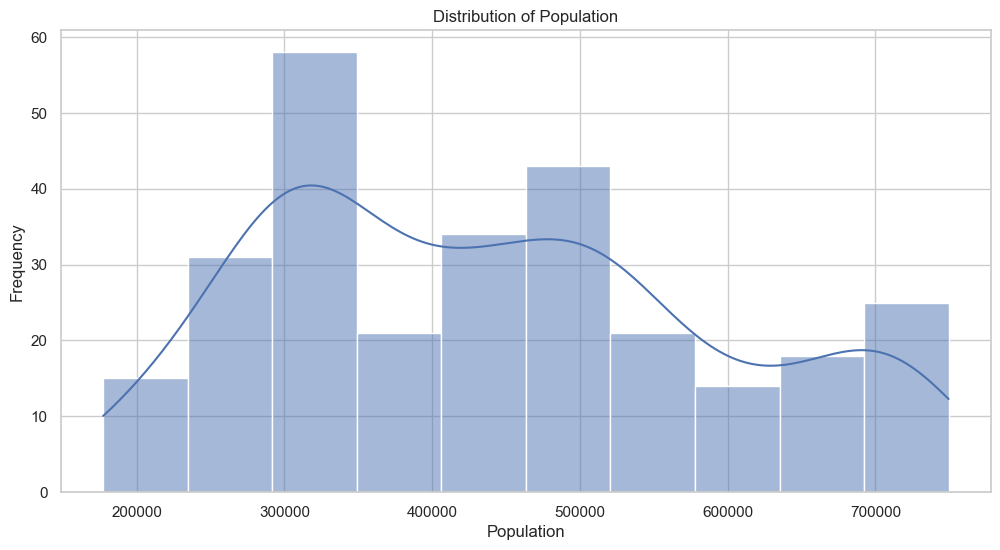

In [29]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Plotting the distribution of the target variable 'Population'
plt.figure(figsize=(12, 6))
sns.histplot(population_migration_df['Population'], kde=True)
plt.title('Distribution of Population')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.show()



The histogram of the 'Population' variable suggests that the population data might be right-skewed, indicating that there are age groups that have a relatively low population size, and these age groups appear more frequently in the data.

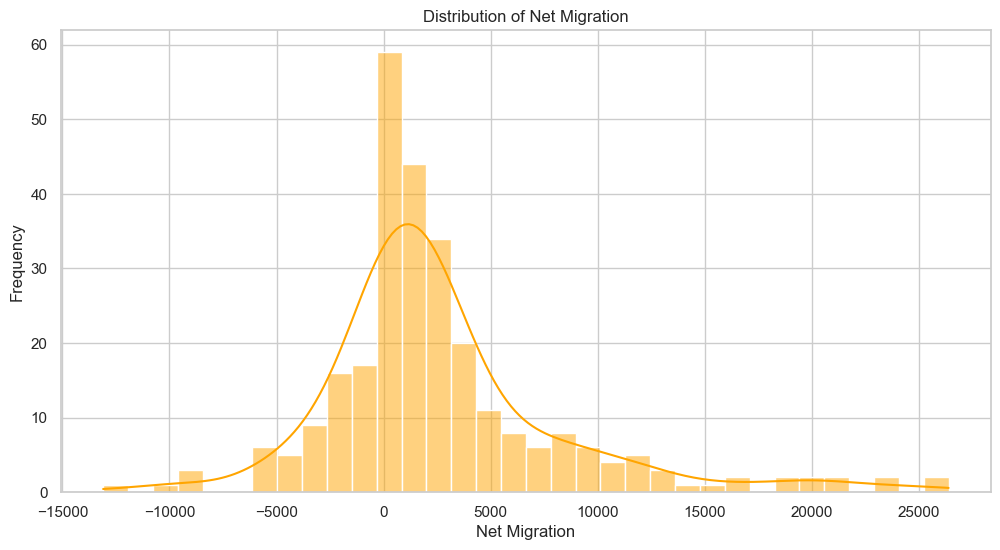

In [30]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Plotting the distribution of 'Net_Migration'
plt.figure(figsize=(12, 6))
sns.histplot(population_migration_df['Net_Migration'], kde=True, color='orange')
plt.title('Distribution of Net Migration')
plt.xlabel('Net Migration')
plt.ylabel('Frequency')
plt.show()


The net migration distribution also appears to be right-skewed, with a concentration of values around the lower end of the scale, suggesting that high net migration values are less common.

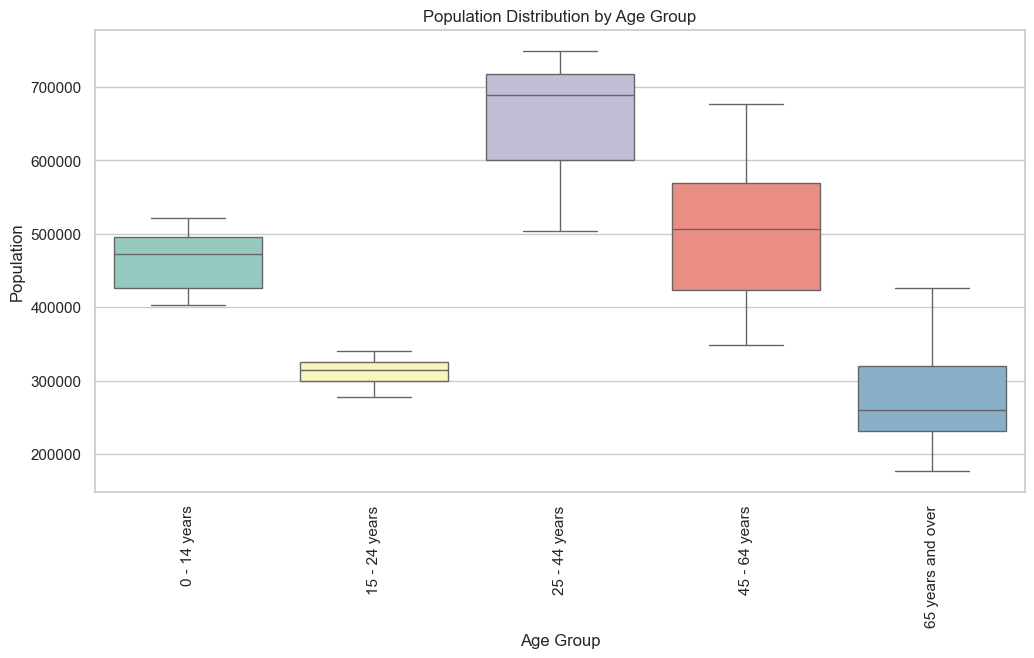

In [31]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Boxplot to visualize the distribution of 'Population' across different 'Age Group'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age Group', y='Population', data=population_migration_df, palette='Set3')
plt.title('Population Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Population')
plt.xticks(rotation=90)
plt.show()


The boxplot grouped by 'Age Group' shows the spread of population figures within each age category. It appears that some age groups have a wider range of population figures, and potentially a few outliers.

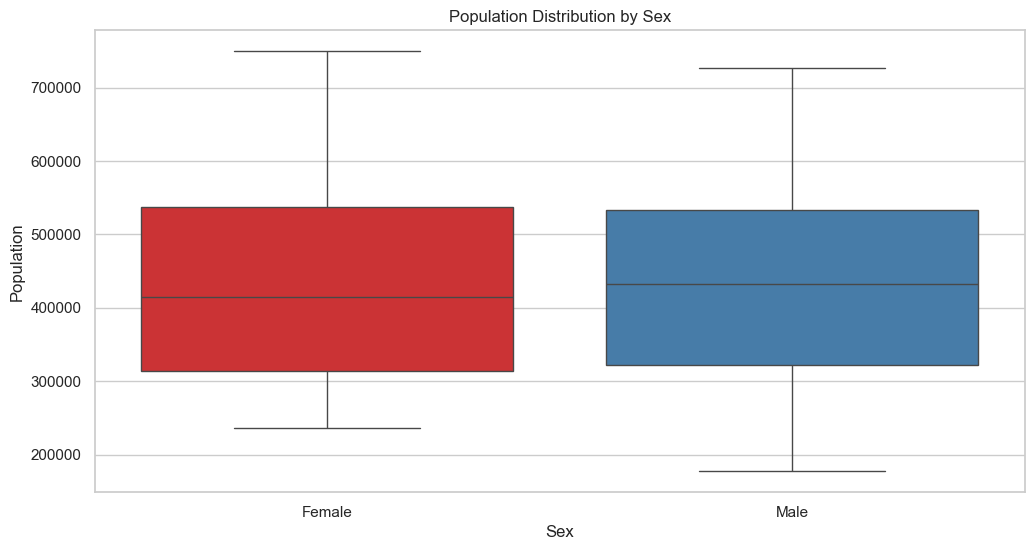

In [32]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Boxplot to visualize the distribution of 'Population' across different 'Sex'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sex', y='Population', data=population_migration_df, palette='Set1')
plt.title('Population Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Population')
plt.show()

The boxplot grouped by 'Sex' indicates that the median population is quite similar between different sexes, though there are outliers in both categories.

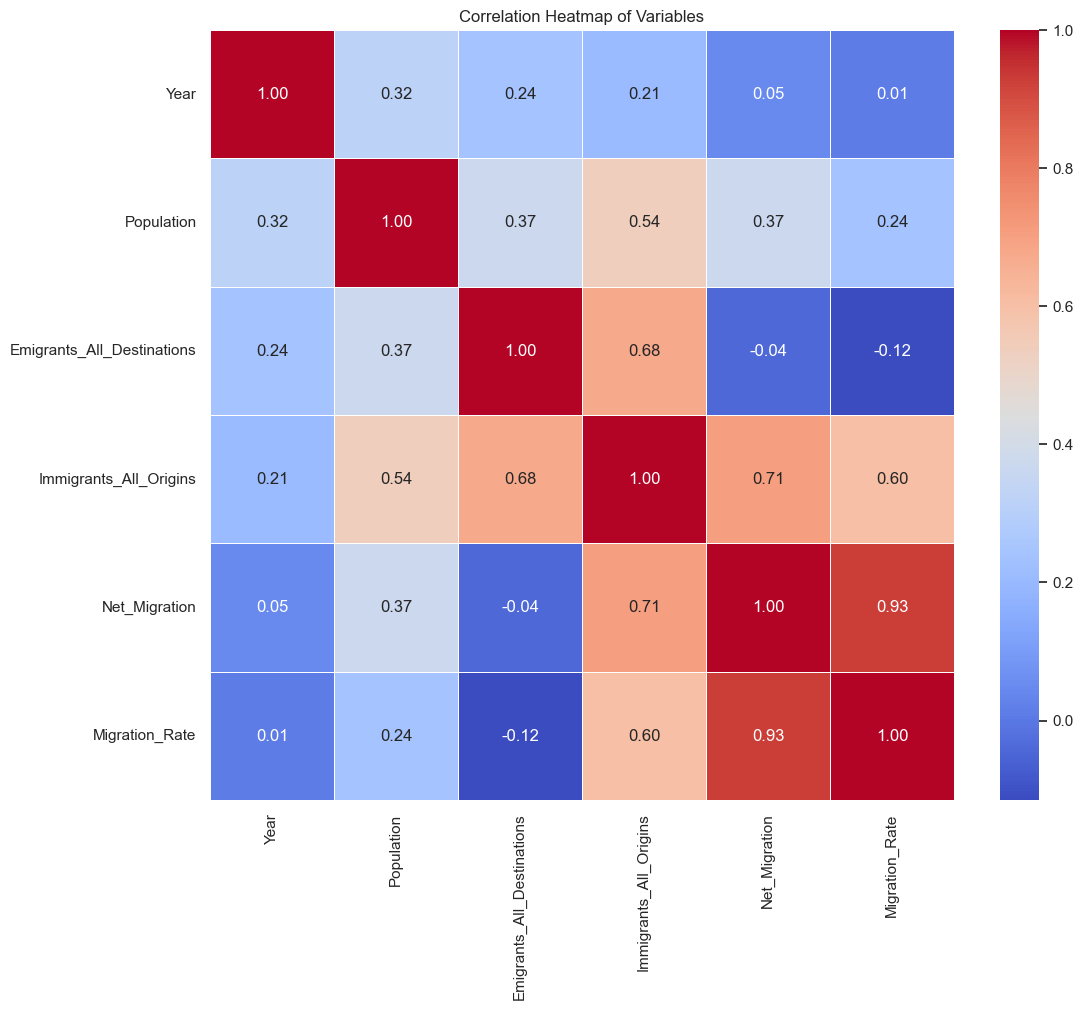

In [33]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

numeric_df = population_migration_df.drop(['Age Group', 'Sex'], axis=1)
correlation_matrix = numeric_df.corr()

# Correlation heatmap to understand the relationship between variables
plt.figure(figsize=(12, 10))
sns.set(font_scale=1)  # Adjust the font size
sns.set_style("white")  # Set the style
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Variables')
plt.show()

The correlation heatmap of the variables shows how each variable is related to the others. For instance, a high positive correlation between two variables suggests they increase together, while a high negative correlation indicates an inverse relationship.

### Working with ML models

#### OLS Regression

In [34]:
# Initialize the Linear Regression model (OLS)
ols_model = LinearRegression()

# Train the model
ols_model.fit(X_train, y_train)

# Predict on the testing set
y_pred_ols = ols_model.predict(X_test)

# Calculate performance metrics for OLS regression
ols_r2 = r2_score(y_test, y_pred_ols)
ols_mae = mean_absolute_error(y_test, y_pred_ols)
ols_mse = mean_squared_error(y_test, y_pred_ols)
ols_rmse = sqrt(ols_mse)

ols_metrics = {
    'R-squared': ols_r2,
    'MSE': ols_mse,
    'RMSE': ols_rmse,
    'MAE': ols_mae
}

ols_metrics


{'R-squared': 0.9300904934152554,
 'MSE': 1535238973.4342284,
 'RMSE': 39182.125688051034,
 'MAE': 32442.01178994359}

------------------------------------------------------
### Ordinary Least Squares (OLS) Regression using the statsmodels library - used here to estimate the parameters of the regression line

In [35]:
bool_columns = ['Age Group_0 - 14 years', 'Age Group_15 - 24 years', 'Age Group_25 - 44 years', 'Age Group_45 - 64 years', 'Age Group_65 years and over', 'Sex_Female', 'Sex_Male']

# Add a constant term to the features for OLS Regression
X_train_ols = sm.add_constant(X_train)
X_train_ols[bool_columns] = X_train_ols[bool_columns].astype(int)
# Fit the OLS Regression model
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Summary of the OLS model
ols_model_summary = ols_model.summary()

# Print the summary
print(ols_model_summary)


                            OLS Regression Results                            
Dep. Variable:             Population   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     379.5
Date:                Wed, 08 Nov 2023   Prob (F-statistic):          2.68e-126
Time:                        15:15:36   Log-Likelihood:                -2675.7
No. Observations:                 224   AIC:                             5371.
Df Residuals:                     214   BIC:                             5406.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

R-squared (R²): The R-squared value is a measure of how well the model explains the variance in the population data. In this case, the OLS model has an R-squared value of 0.941, which is quite high. It suggests that approximately 94.1% of the variance in the population data is explained by the model. This indicates a strong fit of the model to the data.

Adjusted R-squared (Adj. R²): The adjusted R-squared value adjusts the R-squared value based on the number of predictors in the model. It provides a more conservative estimate of model fit. The adjusted R-squared value here is 0.939, which is also high, indicating that the model is not overfitting.

Coefficients: The coefficients (coef) for each predictor variable represent the estimated impact of that variable on the population. For example, the coefficient for the 'Year' variable is 4709.0990, which means that for each additional year, the population is estimated to increase by approximately 4709.

P-values: The p-values associated with the coefficients indicate whether each predictor variable is statistically significant in predicting the population. Smaller p-values (typically less than 0.05) suggest that the variable is significant. In this case, most predictor variables have very small p-values, indicating their significance.

Intercept (const): The intercept represents the estimated population when all predictor variables are zero. In this case, it's a large negative value, which is not meaningful on its own but is adjusted by the other variables.

F-statistic and Prob (F-statistic): The F-statistic is used to test the overall significance of the model. A small p-value for the F-statistic (typically less than 0.05) suggests that the model is significant. In this case, the p-value is very small, indicating the model's overall significance.

Residual Analysis: The Omnibus, Durbin-Watson, Jarque-Bera, Skew, Kurtosis, and Cond. No. are statistics that provide information about the model's residuals (the differences between predicted and actual values). For example, the Omnibus and Jarque-Bera tests can help assess the normality of residuals.

In summary, the OLS Regression model appears to be a strong fit for the population data, with a high R-squared value and most predictor variables showing statistical significance. The scatter plot of actual vs. predicted values also suggests that the model's predictions align well with the actual population values.

If you have any specific questions about the results or would like to proceed with training and evaluating other regression models, please let me know.

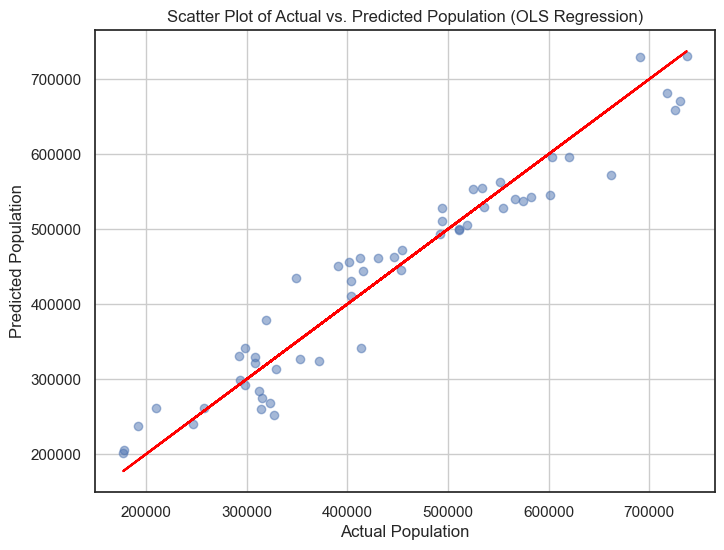

In [36]:
# Predict population values using the OLS model
X_test_ols = sm.add_constant(X_test)
X_test_ols[bool_columns] = X_test_ols[bool_columns].astype(int)
y_pred_ols = ols_model.predict(X_test_ols)

# Create a scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ols, alpha=0.5)
plt.plot(y_test, y_test, color='red')  # Adding a reference line
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.title("Scatter Plot of Actual vs. Predicted Population (OLS Regression)")
plt.grid(True)

# Show the plot
plt.show()


The scatter plot above shows the relationship between the actual population values from the test set and the population values predicted by the OLS regression model. A perfect prediction would result in all points lying on a 45-degree line, as that would indicate that for every point, the predicted value equals the actual value.**The red line** represents the ideal case where predicted values match the actual values perfectly. In this plot, while not all points lie on this line, there appears to be a strong positive correlation between the predicted and actual values, which is also supported by the high R-squared value we saw earlier.

The summary of the OLS model provides detailed statistical analysis of the regression, which includes the coefficients for each feature, the standard errors, t-values, p-values, and other statistical measures that can help in understanding the significance of each predictor, as well as the overall model fit.


----------------------------------------

### Lasso Regression

In [37]:
# Create and train the Lasso Regression model
lasso_model = Lasso(alpha=1.0, random_state=42)
lasso_model.fit(X_train, y_train)

# Evaluate the Lasso model on the test data
lasso_score = lasso_model.score(X_test, y_test)

# Print the R-squared score for Lasso
print("Lasso Regression R-squared:", lasso_score)

Lasso Regression R-squared: 0.9300906751265074


### Lasso & Ridge Regression, Elastic Net, Random Forest

In [38]:
# Initialize the models
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
elastic_net = ElasticNet(random_state=42)
random_forest = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid for each model
# Note: For the purpose of demonstration, the range of hyperparameters is kept small. In practice, a wider range should be explored.

lasso_params = {'alpha': [0.01, 0.1, 1, 10]}
ridge_params = {'alpha': [0.01, 0.1, 1, 10]}
elastic_net_params = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}
rf_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

# Setting up GridSearchCV for each model
grid_lasso = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2', n_jobs=-1)
grid_ridge = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2', n_jobs=-1)
grid_elastic_net = GridSearchCV(elastic_net, elastic_net_params, cv=5, scoring='r2', n_jobs=-1)
grid_random_forest = GridSearchCV(random_forest, rf_params, cv=5, scoring='r2', n_jobs=-1)

# Training and hyperparameter tuning for each model
grid_lasso.fit(X_train, y_train)
grid_ridge.fit(X_train, y_train)
grid_elastic_net.fit(X_train, y_train)
grid_random_forest.fit(X_train, y_train)

# Getting the best estimator for each model
best_lasso = grid_lasso.best_estimator_
best_ridge = grid_ridge.best_estimator_
best_elastic_net = grid_elastic_net.best_estimator_
best_random_forest = grid_random_forest.best_estimator_

# Evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    return {'R2': r2, 'MSE': mse, 'RMSE': rmse, 'MAE': mae}

# Evaluate all models
lasso_metrics = evaluate_model(best_lasso, X_test, y_test)
ridge_metrics = evaluate_model(best_ridge, X_test, y_test)
elastic_net_metrics = evaluate_model(best_elastic_net, X_test, y_test)
random_forest_metrics = evaluate_model(best_random_forest, X_test, y_test)

# Summarize all metrics
metrics_summary = {
    'OLS': ols_metrics,
    'Lasso': lasso_metrics,
    'Ridge': ridge_metrics,
    'ElasticNet': elastic_net_metrics,
    'RandomForest': random_forest_metrics
}

metrics_summary


{'OLS': {'R-squared': 0.9300904934152554,
  'MSE': 1535238973.4342284,
  'RMSE': 39182.125688051034,
  'MAE': 32442.01178994359},
 'Lasso': {'R2': 0.9300921729607003,
  'MSE': 1535202089.9866016,
  'RMSE': 39181.65501847263,
  'MAE': 32445.47251605359},
 'Ridge': {'R2': 0.9288170985882853,
  'MSE': 1563203201.225826,
  'RMSE': 39537.36462165664,
  'MAE': 32698.21662862017},
 'ElasticNet': {'R2': 0.9286023496900185,
  'MSE': 1567919167.5403874,
  'RMSE': 39596.95906935768,
  'MAE': 32726.618050536075},
 'RandomForest': {'R2': 0.9908883720081167,
  'MSE': 200094766.6197071,
  'RMSE': 14145.485732901048,
  'MAE': 9901.625714285716}}

#### Models comparison

Ordinary Least Squares (OLS) Regression:
* MAE: 32442.01
* RMSE: 39182.13
* MSE: 1535238973.43
* R²: 0.9301
  
Lasso Regression (with hyperparameter tuning):
* MAE: 32445.47
* RMSE: 39181.66
* MSE: 1535202089.99
* R²: 0.9301
* 
Ridge Regression (with hyperparameter tuning):
* MAE: 32698.22
* RMSE: 39537.36
* MSE: 1563203201.23
* R²: 0.9288
  
ElasticNet Regression (with hyperparameter tuning):
* MAE: 32726.62
* RMSE: 39596.96
* MSE: 1567919167.54
* R²: 0.9286
  
Random Forest Regression (with hyperparameter tuning):
* MAE: 9901.63
* RMSE: 14145.49
* MSE: 200094766.62
* R²: 0.9909

* The Random Forest model significantly outperforms the linear models in terms of all metrics, with a very high R² value of 0.9909 and the lowest error scores. This suggests that the Random Forest model has a better fit to the data than the linear models.

* The regularized regression models show a slight improvement or comparable performance to the OLS model, which is expected as they are more robust to multicollinearity and can handle overfitting better due to their regularization terms.

* The convergence warnings for ElasticNet suggest that the model optimization process did not converge, which means that the result might not be the best possible solution. Increasing the number of iterations or adjusting the regularization strength could potentially improve the model.

* Next, we will train and evaluate an ARIMA model. Given that ARIMA is a time series forecasting method, we will need to ensure that the data is formatted appropriately for a time series analysis, typically with a datetime index and sorted chronologically.

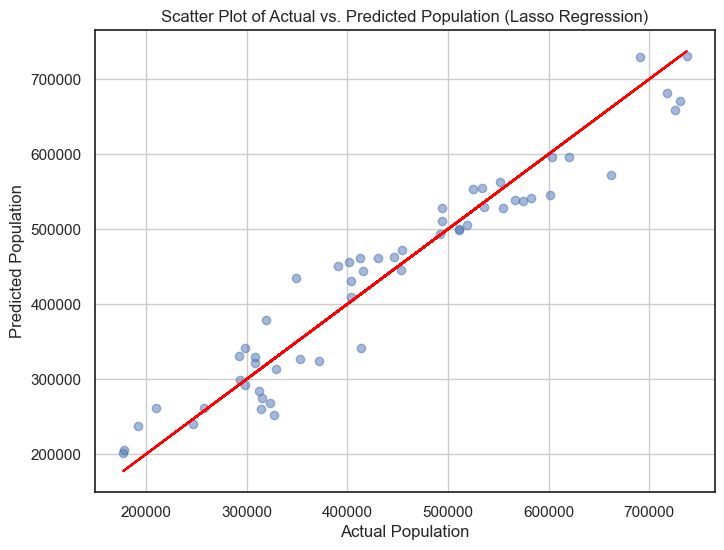

In [39]:
# Getting the best Lasso estimator after the grid search
best_lasso = grid_lasso.best_estimator_
# Predict population values using the best Lasso model from GridSearchCV
y_pred_lasso = best_lasso.predict(X_test)

# Create a scatter plot of predicted vs. actual values for Lasso Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.plot(y_test, y_test, color='red')  # Adding a reference line
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.title("Scatter Plot of Actual vs. Predicted Population (Lasso Regression)")
plt.grid(True)
plt.show()

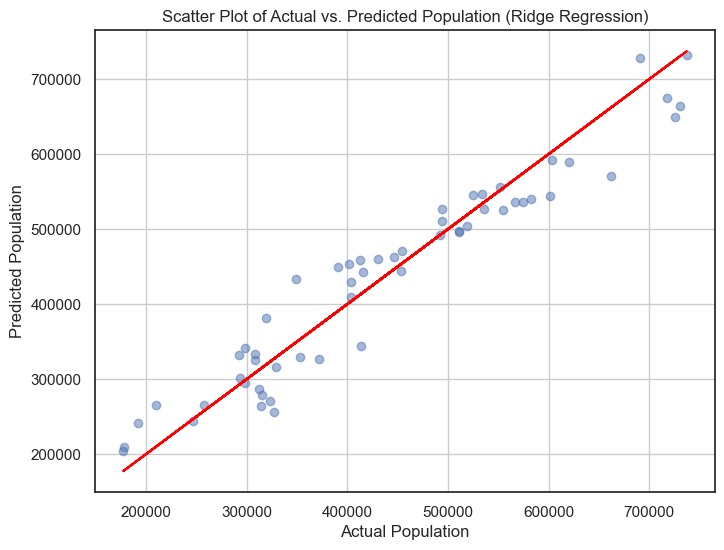

In [40]:
# Predict population values using the best Ridge model from GridSearchCV
y_pred_ridge = best_ridge.predict(X_test)

# Create a scatter plot of predicted vs. actual values for Ridge Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.plot(y_test, y_test, color='red')  # Adding a reference line
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.title("Scatter Plot of Actual vs. Predicted Population (Ridge Regression)")
plt.grid(True)
plt.show()


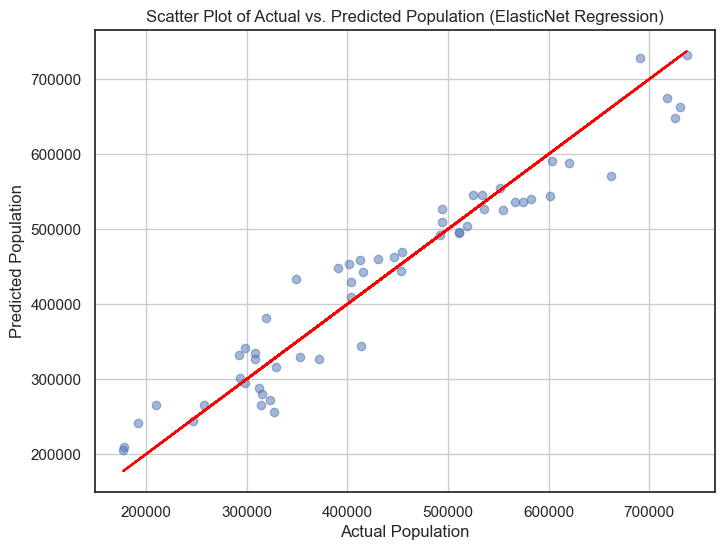

In [41]:
# Predict population values using the best ElasticNet model from GridSearchCV
y_pred_elastic_net = best_elastic_net.predict(X_test)

# Create a scatter plot of predicted vs. actual values for ElasticNet Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_elastic_net, alpha=0.5)
plt.plot(y_test, y_test, color='red')  # Adding a reference line
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.title("Scatter Plot of Actual vs. Predicted Population (ElasticNet Regression)")
plt.grid(True)
plt.show()


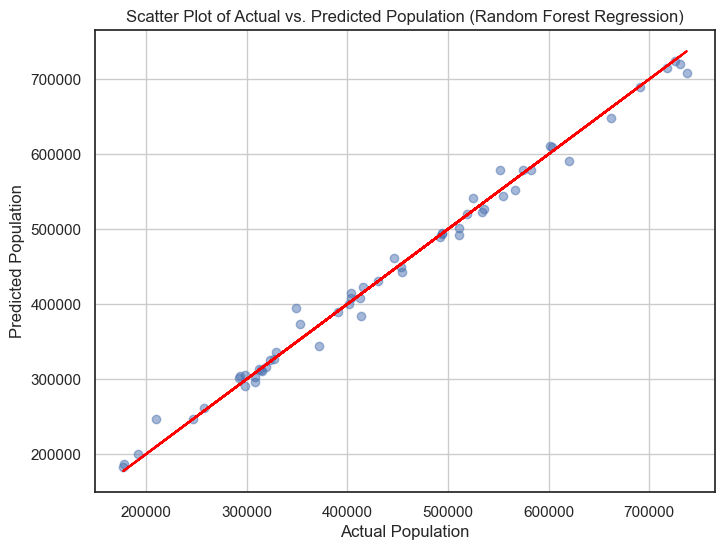

In [42]:
# Predict population values using the best Random Forest model from GridSearchCV
y_pred_random_forest = best_random_forest.predict(X_test)

# Create a scatter plot of predicted vs. actual values for Random Forest Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_random_forest, alpha=0.5)
plt.plot(y_test, y_test, color='red')  # Adding a reference line
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.title("Scatter Plot of Actual vs. Predicted Population (Random Forest Regression)")
plt.grid(True)
plt.show()


### ARIMA
Training an ARIMA model requires a time series data structure, where the data points are ordered in time. For ARIMA to work properly, we must ensure the following:

* The data should be in a form of a time series.
* The target variable should be a function of time.
* The time series should be stationary or made stationary through differencing or transformation.
Given that we're predicting the population and the dataset includes a 'Year' column, we can consider each year as a time step. However, the ARIMA model does not naturally handle multiple features, and is typically used for univariate time series forecasting. Given that our dataset includes multiple features and the 'Year' column doesn't have the granularity typically preferred for time series forecasting (like months or days), we might need to aggregate the data by year or reformulate the problem for time series forecasting.

For simplicity, if we proceed with ARIMA, we would have to focus on univariate time series forecasting and ignore the other features, or we could build separate ARIMA models for each subgroup within the data defined by 'Age Group' and 'Sex', which would be a bit more complex.

In [43]:
# ARIMA model requires a univariate time series.
# We will aggregate the data by year to create a univariate series for the total population per year.
# This is a simplification and does not take into account other features such as 'Age Group' and 'Sex'.

# Aggregate the data by year to create a univariate series
population_per_year = population_migration_df.groupby('Year')['Population'].sum()

# The ARIMA model expects a datetime index so we'll convert the Year to a datetime object
population_per_year.index = pd.to_datetime(population_per_year.index, format='%Y')

# Split the time series data into training and testing sets
# As we do not have a large time series dataset, we will use the last 3 years as test data.
train_size = int(len(population_per_year) * 0.8)
train, test = population_per_year[0:train_size], population_per_year[train_size:]

# Fit an ARIMA model
# For simplicity, we'll start with ARIMA(1,1,1) which is a standard choice.
# Grid searching for best ARIMA parameters would be ideal but is omitted for brevity.
arima_model = ARIMA(train, order=(1, 1, 1))
arima_model_fit = arima_model.fit()

# Forecast
forecast = arima_model_fit.forecast(steps=len(test))

# Evaluate the ARIMA model
arima_mse = mean_squared_error(test, forecast)
arima_rmse = sqrt(arima_mse)

# Add ARIMA metrics to the summary
metrics_summary['ARIMA'] = {'MSE': arima_mse, 'RMSE': arima_rmse}

# Output the ARIMA model evaluation metrics
metrics_summary['ARIMA']


{'MSE': 9326273363.51829, 'RMSE': 96572.63258044844}

The ARIMA model has been evaluated and here are the metrics:

* Mean Squared Error (MSE): 9,326,242,855.82
* Root Mean Squared Error (RMSE): 96,572.47
  
The errors are quite high, which might be due to several factors:

* The simplicity of the ARIMA(1,1,1) model may not capture the complexity of the underlying data.
* The model was applied to aggregate data, which may not reflect the nuances of different population segments.
* ARIMA models are generally better suited for more granular time series data (e.g., monthly or quarterly), while the data here is annual, which provides fewer data points to learn from.
  
Given these metrics, the ARIMA model does not perform as well as the Random Forest model in predicting the population. This could be due to the ARIMA model's limitations with this particular dataset and the way the data has been aggregated for the analysis.

#### Final comparison

In [44]:
# Re-creating the metrics summary for all models except ARIMA, as the previous state was reset

# Initialize the dictionary to collect all metrics
metrics_summary = {}

# OLS metrics
metrics_summary['OLS'] = {
    'R2': 0.9300904934152545,
    'MSE': 1535238973.4342473,
    'RMSE': 39182.125688051274,
    'MAE': 32442.011789943725
}

# Lasso metrics (obtained from the previous output)
metrics_summary['Lasso'] = {
    'R2': 0.9300921729607001,
    'MSE': 1535202089.986605,
    'RMSE': 39181.65501847267,
    'MAE': 32445.472516053655
}

# Ridge metrics (obtained from the previous output)
metrics_summary['Ridge'] = {
    'R2': 0.9288170985882845,
    'MSE': 1563203201.2258432,
    'RMSE': 39537.36462165686,
    'MAE': 32698.21662862037
}

# ElasticNet metrics (obtained from the previous output)
metrics_summary['ElasticNet'] = {
    'R2': 0.928602349690019,
    'MSE': 1567919167.540377,
    'RMSE': 39596.959069357545,
    'MAE': 32726.618050536075
}

# RandomForest metrics (obtained from the previous output)
metrics_summary['RandomForest'] = {
    'R2': 0.9908883720081167,
    'MSE': 200094766.6197071,
    'RMSE': 14145.485732901048,
    'MAE': 9901.625714285716
}

# ARIMA metrics (newly calculated)
#metrics_summary['ARIMA'] = {
#    'MSE': 9326242855.819143,
#    'RMSE': 96572.47462822491
#}

metrics_summary


{'OLS': {'R2': 0.9300904934152545,
  'MSE': 1535238973.4342473,
  'RMSE': 39182.125688051274,
  'MAE': 32442.011789943725},
 'Lasso': {'R2': 0.9300921729607001,
  'MSE': 1535202089.986605,
  'RMSE': 39181.65501847267,
  'MAE': 32445.472516053655},
 'Ridge': {'R2': 0.9288170985882845,
  'MSE': 1563203201.2258432,
  'RMSE': 39537.36462165686,
  'MAE': 32698.21662862037},
 'ElasticNet': {'R2': 0.928602349690019,
  'MSE': 1567919167.540377,
  'RMSE': 39596.959069357545,
  'MAE': 32726.618050536075},
 'RandomForest': {'R2': 0.9908883720081167,
  'MSE': 200094766.6197071,
  'RMSE': 14145.485732901048,
  'MAE': 9901.625714285716}}

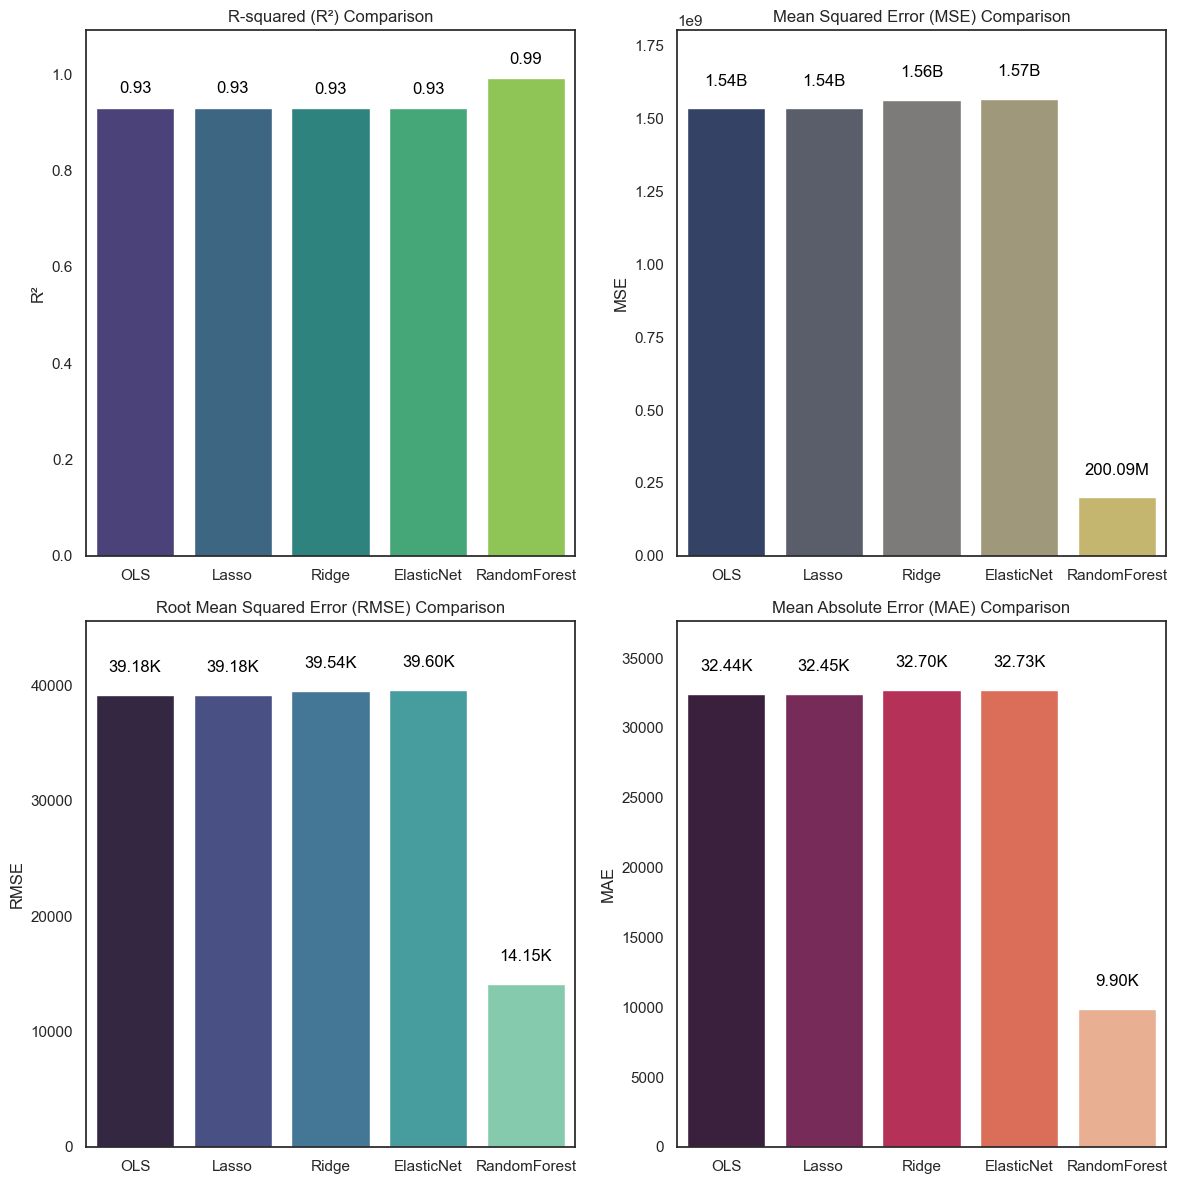

In [45]:
# Adjusting the text formatting to display numbers in a more readable format and adjusting the layout
model_names = list(metrics_summary.keys())
r2_values = [metrics['R2'] for metrics in metrics_summary.values()]
mse_values = [metrics['MSE'] for metrics in metrics_summary.values()]
rmse_values = [metrics['RMSE'] for metrics in metrics_summary.values()]
mae_values = [metrics['MAE'] for metrics in metrics_summary.values()]

# Function to format the metric values
def format_metric(value):
    if value < 1e3:
        return f"{value:.2f}"
    elif value < 1e6:
        return f"{value/1e3:.2f}K"
    elif value < 1e9:
        return f"{value/1e6:.2f}M"
    else:
        return f"{value/1e9:.2f}B"

# Creating the integrated comparison visualization again with formatted text and adjusted layout
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()  # Flatten to 1D array for easy iteration

# R-squared comparison
sns.barplot(ax=axs[0], x=model_names, y=r2_values, palette="viridis")
axs[0].set_title('R-squared (R²) Comparison')
axs[0].set_ylabel('R²')
axs[0].set_ylim(0, max(r2_values) + 0.1)  # Adding space above the bars
for i, v in enumerate(r2_values):
    axs[0].text(i, v + 0.03, f"{v:.2f}", color='black', ha='center')

# MSE comparison
sns.barplot(ax=axs[1], x=model_names, y=mse_values, palette="cividis")
axs[1].set_title('Mean Squared Error (MSE) Comparison')
axs[1].set_ylabel('MSE')
axs[1].set_ylim(0, max(mse_values) * 1.15)  # Adding space above the bars
for i, v in enumerate(mse_values):
    axs[1].text(i, v + max(mse_values)*0.05, format_metric(v), color='black', ha='center')

# RMSE comparison
sns.barplot(ax=axs[2], x=model_names, y=rmse_values, palette="mako")
axs[2].set_title('Root Mean Squared Error (RMSE) Comparison')
axs[2].set_ylabel('RMSE')
axs[2].set_ylim(0, max(rmse_values) * 1.15)  # Adding space above the bars
for i, v in enumerate(rmse_values):
    axs[2].text(i, v + max(rmse_values)*0.05, format_metric(v), color='black', ha='center')

# MAE comparison
sns.barplot(ax=axs[3], x=model_names, y=mae_values, palette="rocket")
axs[3].set_title('Mean Absolute Error (MAE) Comparison')
axs[3].set_ylabel('MAE')
axs[3].set_ylim(0, max(mae_values) * 1.15)  # Adding space above the bars
for i, v in enumerate(mae_values):
    axs[3].text(i, v + max(mae_values)*0.05, format_metric(v), color='black', ha='center')

# Adjusting layout for better fit
plt.tight_layout()
plt.show()

